# Where is the most appropriate place to set a new gym?: The case of Madrid, city.

The main goal of this exercise is to provide the best location to establish a gym aimed at people with middle-high income in Madrid. Using data about the neighborhoods like average income, average age, unemployment, and similar venues placed, among others.

- Setting up the enviroment

In [1]:
#Changing the working directory
import os
os.chdir("C:/Users/leang/OneDrive/Cursos_Online/Data Science/IBM certification/Final project")
os.getcwd()

'C:\\Users\\leang\\OneDrive\\Cursos_Online\\Data Science\\IBM certification\\Final project'

In [2]:
#libraries needed 

import pandas as pd
import numpy as np
import requests
import json 
#!pip install geopy
import geopy
#!pip install folium
import folium 
from geopy.geocoders import Nominatim
from bs4 import BeautifulSoup
from pandas.io.json import json_normalize
# Matplotlib and associated plotting modules
import matplotlib.cm as cm
import matplotlib.colors as colors
import matplotlib.pyplot as plt

# import k-means from clustering stage
from sklearn.cluster import KMeans

- Loading and setting the data

In [3]:
#loading files
income_df = pd.read_csv("renta.csv", sep = ";", skiprows = 3, encoding = 'latin1', error_bad_lines=False, dtype = {"Renta media": str})
age_df = pd.read_csv("edad.csv", sep = ";", skiprows = 3, encoding = 'latin1', error_bad_lines=False)
unemp_df = pd.read_csv("paro.csv", sep = ";", skiprows = 3, encoding = 'latin1', error_bad_lines=False)

In [4]:
#DF´s shape
print("size of income df:", income_df.shape)
print("size of age df:", age_df.shape)
print("size of unemployment df:", unemp_df.shape)

size of income df: (131, 4)
size of age df: (131, 4)
size of unemployment df: (131, 4)


In [5]:
#parsing strings
income_df["Renta media"] = income_df["Renta media"].str.replace(".", "").astype(int)
age_df["Edad media"] = age_df["Edad media"].str.replace(",", ".").astype(float)
unemp_df["Tasa paro"] = unemp_df["Tasa paro"].str.replace(",", ".").astype(float)

In [6]:
#Dropping the first columns
income_df.drop("Orden", axis = 1, inplace = True)
age_df.drop("Orden", axis = 1, inplace = True)
unemp_df.drop("Orden", axis = 1, inplace = True)

In [7]:
#merging df´s
tempdf = pd.merge(left = income_df, right = age_df[["Cod. Territorio", "Edad media"]], on = "Cod. Territorio")
merge_df = pd.merge(left = tempdf, right = unemp_df[["Cod. Territorio", "Tasa paro"]], on = "Cod. Territorio")

In [8]:
merge_df.head()

,Cod. Territorio,Territorio,Renta media,Edad media,Tasa paro
0,28079BAR096,El Plantío,89215,42.6,4.25
1,28079BAR095,Valdemarín,88243,36.7,3.70
2,28079BAR082,Fuentelarreina,84239,45.3,4.42
3,28079BAR162,Piovera,81938,41.0,4.96
4,28079BAR161,Palomas,81073,40.3,6.05


- Analyzing the dataset

In [9]:
# Summary statistics
merge_df.describe()

,Renta media,Edad media,Tasa paro
count,131.000000,131.000000,131.000000
mean,42378.412214,43.981679,9.209695
std,16434.315618,3.405941,3.071082
min,20365.000000,33.200000,3.700000
25%,29616.000000,42.500000,6.830000
50%,37373.000000,44.800000,8.890000
75%,50932.500000,46.300000,11.460000
max,89215.000000,49.300000,17.580000


Text(0.5, 1.0, 'Renta media - Paro')

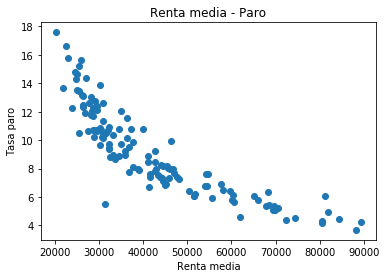

In [10]:
#Plotting relation between income and unemployment
plt.scatter(merge_df["Renta media"], merge_df["Tasa paro"])
plt.xlabel("Renta media")
plt.ylabel("Tasa paro")
plt.title("Renta media - Paro")

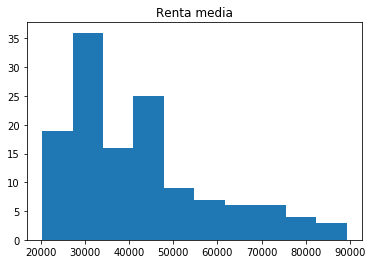

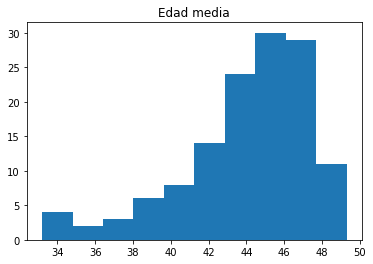

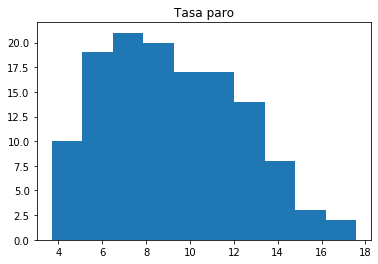

In [11]:
#Plotting income, age and unemployment distribution
plt.figure(1)
plt.hist(merge_df["Renta media"])
plt.title("Renta media")
plt.figure(2)
plt.hist(merge_df["Edad media"])
plt.title("Edad media")
plt.figure(3)
plt.hist(merge_df["Tasa paro"])
plt.title("Tasa paro")
plt.show()

- Retrieving the latitude, longitude and venues of each neighborhood 

In [12]:
# Creating a list with the neighborhoods to be search
neigh = merge_df["Territorio"]
neigh = neigh + ", Madrid"
neigh

0          El Plantío, Madrid
1          Valdemarín, Madrid
2      Fuentelarreina, Madrid
3             Piovera, Madrid
4             Palomas, Madrid
                ...          
126        Pradolongo, Madrid
127         Entrevías, Madrid
128           Amposta, Madrid
129         San Diego, Madrid
130     San Cristóbal, Madrid
Name: Territorio, Length: 131, dtype: object

In [13]:
# Getting the geographical coordinates of each neighborhood.

geolocator = Nominatim(user_agent="madrid")

lat = []
lon = []

for i in neigh:
    location = geolocator.geocode(i)
    if location is None:
        latitude = np.nan
        longitude = np.nan
    else:
        latitude = location.latitude
        longitude = location.longitude
    
    #print(i, latitude, longitude)
    lat.append(latitude)
    lon.append(longitude)

In [14]:
# Appending latitude and longitude to the dataset
merge_df["Latitude"] = lat
merge_df["Longitude"] = lon

In [15]:
# droping NA´s

merge_df.dropna(inplace = True)
merge_df.shape

(129, 7)

Let´s Create a map of Madrid with neighborhoods superimposed on top.

In [16]:
# Retrieving the latitude and longitude of Madrid

address = 'Madrid, Spain'

geolocator = Nominatim(user_agent="madrid_explorer")
location_M = geolocator.geocode(address)
latitude_M = location_M.latitude
longitude_M = location_M.longitude
print('The geograpical coordinates of Madrid are {}, {}.'.format(latitude, longitude))

The geograpical coordinates of Madrid are 40.3433537, -3.6878175.


In [17]:
# Create map of Madrid using latitude and longitude values

map_madrid = folium.Map(location=[latitude_M, longitude_M], zoom_start=11)

# add markers to map
for lat, lng, neighb in zip(merge_df['Latitude'], merge_df['Longitude'], merge_df['Territorio']):
    #label = '{}, {}'.format(neighborhood, borough)
    label = folium.Popup(neighb, parse_html=True)
    folium.CircleMarker(
        [lat, lng],
        radius=5,
        popup=label,
        color='blue',
        fill=True,
        fill_color='#3186cc',
        fill_opacity=0.7,
        parse_html=False).add_to(map_madrid)  
    
map_madrid

Let's retrieve the information about venues in each neighborhood of Madrid using the Foursquare API

In [18]:
# Defining Foursquare Credentials and Version
CLIENT_ID = 'PZNM1XLH0YX4P4I3HKFRT14RST1EFYTNK1BWI0DQ05QKTE5B' # your Foursquare ID
CLIENT_SECRET = 'UHWBV3KVSBAS2ZUBICPPDWLNCAY0PHGQE5JCM5X1KN332WLN' # your Foursquare Secret
VERSION = '20180605' # Foursquare API version
LIMIT = 100 # A default Foursquare API limit value

In [19]:
# function to extract the venues and categories of all the neighborhoods in Madrid
def getNearbyVenues(names, latitudes, longitudes, radius=500):
    
    venues_list=[]
    for name, lat, lng in zip(names, latitudes, longitudes):
        print(name)
            
        # create the API request URL
        url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(
            CLIENT_ID, 
            CLIENT_SECRET, 
            VERSION, 
            lat, 
            lng, 
            radius, 
            LIMIT)
            
        # make the GET request
        results = requests.get(url).json()["response"]['groups'][0]['items']
        
        # return only relevant information for each nearby venue
        venues_list.append([(
            name, 
            lat, 
            lng, 
            v['venue']['name'], 
            v['venue']['location']['lat'], 
            v['venue']['location']['lng'],  
            v['venue']['categories'][0]['name']) for v in results])

    nearby_venues = pd.DataFrame([item for venue_list in venues_list for item in venue_list])
    nearby_venues.columns = ['Neighborhood', 
                  'Neighborhood Latitude', 
                  'Neighborhood Longitude', 
                  'Venue', 
                  'Venue Latitude', 
                  'Venue Longitude', 
                  'Venue Category']
    
    return(nearby_venues)

In [20]:
# Running the above function to retrieve the information

madrid_venues = getNearbyVenues(names = merge_df['Territorio'],
                                latitudes = merge_df['Latitude'],
                                longitudes = merge_df['Longitude']
                                )

El Plantío
Valdemarín
Fuentelarreina
Piovera
Palomas
El Viso
Recoletos
Nueva España
Castellana
Jerónimos
Mirasierra
Almagro
Aravaca
Corralejos
Atalaya
Niño Jesús
Hispanoamérica
Costillares
El Goloso
Ciudad Universitaria
Estrella
Vallehermoso
La Paz
Castilla
San Juan Bautista
Valdefuentes
Colina
Argüelles
Salvador
Alameda de Osuna
Goya
Legazpi
Lista
Ríos Rosas
Ibiza
Guindalera
Castillejos
Peñagrande
Horcajo
Acacias
Adelfas
Prosperidad
Ciudad Jardín
Gaztambide
Rosas
Cuatro Caminos
Valverde
Arapiles
Imperial
Trafalgar
Pacífico
Justicia
San Pascual
Casa de Campo
Fuente del Berro
Delicias
Timón
Valderribas
Canillas
Marroquina
Valdebernardo
Rejas
Atocha
Cortes
Apóstol Santiago
Santa Eugenia
Cuatro Vientos
El Pardo
Media Legua
Palacio
Valdezarza
Palos de Moguer
Concepción
Pavones
Pilar
Pinar del Rey
Ensanche de Vallecas
Chopera
Universidad
Sol
Campamento
Bellas Vistas
Canillejas
Buenavista
Simancas
Aluche
El Cañaveral
Pueblo Nuevo
Quintana
Lucero
Almenara
Las Águilas
Butarque
Berruguete
Arcos

In [21]:
#checking the output
print(madrid_venues.shape)
madrid_venues.head()

(3680, 7)


,Neighborhood,Neighborhood Latitude,Neighborhood Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
0,El Plantío,40.468442,-3.817696,Carús,40.466922,-3.814156,Spanish Restaurant
1,El Plantío,40.468442,-3.817696,Patrick Sport,40.467823,-3.814744,Sporting Goods Shop
2,El Plantío,40.468442,-3.817696,Gaztelubide,40.467642,-3.812047,Spanish Restaurant
3,El Plantío,40.468442,-3.817696,Los Remos,40.468446,-3.812641,Seafood Restaurant
4,El Plantío,40.468442,-3.817696,O2 Centro Wellness,40.468329,-3.815313,Gym


In [22]:
# filtering or deleting in the dataset the venue category with values equals to neighborhood
madrid_venues = madrid_venues[madrid_venues["Venue Category"] != "Neighborhood"]

In [23]:
#checking the output "again"
print(madrid_venues.shape)
madrid_venues.head()

(3678, 7)


,Neighborhood,Neighborhood Latitude,Neighborhood Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
0,El Plantío,40.468442,-3.817696,Carús,40.466922,-3.814156,Spanish Restaurant
1,El Plantío,40.468442,-3.817696,Patrick Sport,40.467823,-3.814744,Sporting Goods Shop
2,El Plantío,40.468442,-3.817696,Gaztelubide,40.467642,-3.812047,Spanish Restaurant
3,El Plantío,40.468442,-3.817696,Los Remos,40.468446,-3.812641,Seafood Restaurant
4,El Plantío,40.468442,-3.817696,O2 Centro Wellness,40.468329,-3.815313,Gym


In [24]:
#checking how many venues were returned for each neighborhood
pd.set_option('display.max_rows', None)
madrid_venues.groupby('Neighborhood').count().iloc[:,1]

Neighborhood
Abrantes                                            8
Acacias                                            43
Adelfas                                            41
Alameda de Osuna                                   22
Almagro                                           100
Almenara                                           14
Almendrales                                        17
Aluche                                             10
Amposta                                             6
Apóstol Santiago                                   36
Arapiles                                           72
Aravaca                                             6
Arcos                                              12
Argüelles                                          65
Atalaya                                             9
Atocha                                             45
Bellas Vistas                                      44
Berruguete                                         34
Buenavista     

In [25]:
#Cheking how many unique categories can be curated from all the returned venues
print('There are {} uniques categories.'.format(len(madrid_venues['Venue Category'].unique())))

There are 264 uniques categories.


Let´s Analyze Each Neighborhood

In [26]:
# one hot encoding
madrid_onehot = pd.get_dummies(madrid_venues[['Venue Category']], prefix="", prefix_sep="")

# add neighborhood column back to dataframe
madrid_onehot['Neighborhood'] = madrid_venues['Neighborhood'] 

# move neighborhood column to the first column
fixed_columns = [madrid_onehot.columns[-1]] + list(madrid_onehot.columns[:-1])
madrid_onehot = madrid_onehot[fixed_columns]

pd.set_option('display.max_columns', None)
madrid_onehot.head()

,Neighborhood,Accessories Store,Adult Boutique,Airport,American Restaurant,Arcade,Arepa Restaurant,Argentinian Restaurant,Art Gallery,Art Museum,Art Studio,Arts & Crafts Store,Asian Restaurant,Athletics & Sports,BBQ Joint,Bagel Shop,Bakery,Bar,Basketball Court,Basketball Stadium,Bed & Breakfast,Beer Bar,Beer Garden,Beer Store,Big Box Store,Bistro,Board Shop,Boarding House,Bookstore,Boutique,Boxing Gym,Brazilian Restaurant,Breakfast Spot,Brewery,Bridge,Bubble Tea Shop,Building,Burger Joint,Burrito Place,Bus Station,Cafeteria,Café,Camera Store,Casino,Cheese Shop,Chinese Restaurant,Chocolate Shop,Church,Circus,Clothing Store,Cocktail Bar,Coffee Shop,College Auditorium,College Gym,Colombian Restaurant,Comedy Club,Comfort Food Restaurant,Comic Shop,Concert Hall,Convenience Store,Cosmetics Shop,Creperie,Cuban Restaurant,Cupcake Shop,Dance Studio,Deli / Bodega,Department Store,Dessert Shop,Diner,Disc Golf,Discount Store,Dive Shop,Dog Run,Donut Shop,Dumpling Restaurant,Eastern European Restaurant,Electronics Store,Embassy / Consulate,Escape Room,Ethiopian Restaurant,Event Space,Fabric Shop,Falafel Restaurant,Farmers Market,Fast Food Restaurant,Fish & Chips Shop,Fish Market,Flea Market,Flower Shop,Food,Food & Drink Shop,Food Stand,Football Stadium,Fountain,French Restaurant,Fried Chicken Joint,Frozen Yogurt Shop,Furniture / Home Store,Garden,Gas Station,Gastropub,Gay Bar,General Entertainment,German Restaurant,Gift Shop,Gluten-free Restaurant,Golf Course,Gourmet Shop,Government Building,Greek Restaurant,Grilled Meat Restaurant,Grocery Store,Gun Range,Gym,Gym / Fitness Center,Gym Pool,Gymnastics Gym,Health & Beauty Service,Health Food Store,Herbs & Spices Store,Historic Site,History Museum,Hobby Shop,Home Service,Hostel,Hot Dog Joint,Hotel,Hotel Bar,Ice Cream Shop,Indian Restaurant,Indie Movie Theater,Indie Theater,Internet Cafe,Irish Pub,Italian Restaurant,Japanese Restaurant,Jazz Club,Jewelry Store,Juice Bar,Karaoke Bar,Kebab Restaurant,Kids Store,Korean Restaurant,Lake,Latin American Restaurant,Library,Light Rail Station,Lingerie Store,Liquor Store,Locksmith,Lounge,Market,Massage Studio,Mediterranean Restaurant,Men's Store,Metro Station,Mexican Restaurant,Middle Eastern Restaurant,Miscellaneous Shop,Mobile Phone Shop,Modern European Restaurant,Molecular Gastronomy Restaurant,Monument / Landmark,Motorcycle Shop,Movie Theater,Multiplex,Museum,Music School,Music Store,Music Venue,Nail Salon,New American Restaurant,Nightclub,Nightlife Spot,Noodle House,North Indian Restaurant,Office,Optical Shop,Other Great Outdoors,Other Nightlife,Outdoor Sculpture,Outdoors & Recreation,Paella Restaurant,Palace,Paper / Office Supplies Store,Park,Pastry Shop,Performing Arts Venue,Perfume Shop,Peruvian Restaurant,Pet Café,Pet Store,Pharmacy,Piano Bar,Pie Shop,Pizza Place,Platform,Playground,Plaza,Pool,Portuguese Restaurant,Pub,Public Art,Ramen Restaurant,Rental Car Location,Rental Service,Resort,Restaurant,Road,Roof Deck,Salad Place,Salon / Barbershop,Sandwich Place,Scandinavian Restaurant,Scenic Lookout,Science Museum,Sculpture Garden,Seafood Restaurant,Shoe Store,Shop & Service,Shopping Mall,Skate Park,Skating Rink,Smoke Shop,Smoothie Shop,Snack Place,Soccer Field,Soccer Stadium,South American Restaurant,Spa,Spanish Restaurant,Sporting Goods Shop,Sports Bar,Sports Club,Stadium,Steakhouse,Supermarket,Sushi Restaurant,Swiss Restaurant,Szechuan Restaurant,Taco Place,Tapas Restaurant,Tattoo Parlor,Tea Room,Tennis Court,Thai Restaurant,Theater,Theme Restaurant,Thrift / Vintage Store,Toy / Game Store,Track,Track Stadium,Trade School,Train Station,Travel Lounge,Udon Restaurant,Used Bookstore,Vegetarian / Vegan Restaurant,Venezuelan Restaurant,Video Game Store,Whisky Bar,Wine Bar,Wine Shop,Women's Store,Yoga Studio
0,El Plantío,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0

In [27]:
#create a new variable that unifies those related to gyms
madrid_onehot['Gyms'] = np.where((madrid_onehot["Gym"] == 1) | (madrid_onehot["Gym / Fitness Center"] == 1), 1, 0)
madrid_onehot.drop(["Gym", "Gym / Fitness Center"], axis = 1, inplace = True)
madrid_onehot.head()

,Neighborhood,Accessories Store,Adult Boutique,Airport,American Restaurant,Arcade,Arepa Restaurant,Argentinian Restaurant,Art Gallery,Art Museum,Art Studio,Arts & Crafts Store,Asian Restaurant,Athletics & Sports,BBQ Joint,Bagel Shop,Bakery,Bar,Basketball Court,Basketball Stadium,Bed & Breakfast,Beer Bar,Beer Garden,Beer Store,Big Box Store,Bistro,Board Shop,Boarding House,Bookstore,Boutique,Boxing Gym,Brazilian Restaurant,Breakfast Spot,Brewery,Bridge,Bubble Tea Shop,Building,Burger Joint,Burrito Place,Bus Station,Cafeteria,Café,Camera Store,Casino,Cheese Shop,Chinese Restaurant,Chocolate Shop,Church,Circus,Clothing Store,Cocktail Bar,Coffee Shop,College Auditorium,College Gym,Colombian Restaurant,Comedy Club,Comfort Food Restaurant,Comic Shop,Concert Hall,Convenience Store,Cosmetics Shop,Creperie,Cuban Restaurant,Cupcake Shop,Dance Studio,Deli / Bodega,Department Store,Dessert Shop,Diner,Disc Golf,Discount Store,Dive Shop,Dog Run,Donut Shop,Dumpling Restaurant,Eastern European Restaurant,Electronics Store,Embassy / Consulate,Escape Room,Ethiopian Restaurant,Event Space,Fabric Shop,Falafel Restaurant,Farmers Market,Fast Food Restaurant,Fish & Chips Shop,Fish Market,Flea Market,Flower Shop,Food,Food & Drink Shop,Food Stand,Football Stadium,Fountain,French Restaurant,Fried Chicken Joint,Frozen Yogurt Shop,Furniture / Home Store,Garden,Gas Station,Gastropub,Gay Bar,General Entertainment,German Restaurant,Gift Shop,Gluten-free Restaurant,Golf Course,Gourmet Shop,Government Building,Greek Restaurant,Grilled Meat Restaurant,Grocery Store,Gun Range,Gym Pool,Gymnastics Gym,Health & Beauty Service,Health Food Store,Herbs & Spices Store,Historic Site,History Museum,Hobby Shop,Home Service,Hostel,Hot Dog Joint,Hotel,Hotel Bar,Ice Cream Shop,Indian Restaurant,Indie Movie Theater,Indie Theater,Internet Cafe,Irish Pub,Italian Restaurant,Japanese Restaurant,Jazz Club,Jewelry Store,Juice Bar,Karaoke Bar,Kebab Restaurant,Kids Store,Korean Restaurant,Lake,Latin American Restaurant,Library,Light Rail Station,Lingerie Store,Liquor Store,Locksmith,Lounge,Market,Massage Studio,Mediterranean Restaurant,Men's Store,Metro Station,Mexican Restaurant,Middle Eastern Restaurant,Miscellaneous Shop,Mobile Phone Shop,Modern European Restaurant,Molecular Gastronomy Restaurant,Monument / Landmark,Motorcycle Shop,Movie Theater,Multiplex,Museum,Music School,Music Store,Music Venue,Nail Salon,New American Restaurant,Nightclub,Nightlife Spot,Noodle House,North Indian Restaurant,Office,Optical Shop,Other Great Outdoors,Other Nightlife,Outdoor Sculpture,Outdoors & Recreation,Paella Restaurant,Palace,Paper / Office Supplies Store,Park,Pastry Shop,Performing Arts Venue,Perfume Shop,Peruvian Restaurant,Pet Café,Pet Store,Pharmacy,Piano Bar,Pie Shop,Pizza Place,Platform,Playground,Plaza,Pool,Portuguese Restaurant,Pub,Public Art,Ramen Restaurant,Rental Car Location,Rental Service,Resort,Restaurant,Road,Roof Deck,Salad Place,Salon / Barbershop,Sandwich Place,Scandinavian Restaurant,Scenic Lookout,Science Museum,Sculpture Garden,Seafood Restaurant,Shoe Store,Shop & Service,Shopping Mall,Skate Park,Skating Rink,Smoke Shop,Smoothie Shop,Snack Place,Soccer Field,Soccer Stadium,South American Restaurant,Spa,Spanish Restaurant,Sporting Goods Shop,Sports Bar,Sports Club,Stadium,Steakhouse,Supermarket,Sushi Restaurant,Swiss Restaurant,Szechuan Restaurant,Taco Place,Tapas Restaurant,Tattoo Parlor,Tea Room,Tennis Court,Thai Restaurant,Theater,Theme Restaurant,Thrift / Vintage Store,Toy / Game Store,Track,Track Stadium,Trade School,Train Station,Travel Lounge,Udon Restaurant,Used Bookstore,Vegetarian / Vegan Restaurant,Venezuelan Restaurant,Video Game Store,Whisky Bar,Wine Bar,Wine Shop,Women's Store,Yoga Studio,Gyms
0,El Plantío,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0

In [28]:
# New dataframe size
madrid_onehot.shape

(3678, 264)

In [29]:
# Grouping rows by neighborhood and taking the mean of the frequency of occurrence of each category
pd.reset_option("display.max_columns")
pd.reset_option("display.max_rows")
madrid_grouped = madrid_onehot.groupby('Neighborhood').mean().reset_index()
madrid_grouped

,Neighborhood,Accessories Store,Adult Boutique,Airport,American Restaurant,Arcade,Arepa Restaurant,Argentinian Restaurant,Art Gallery,Art Museum,...,Used Bookstore,Vegetarian / Vegan Restaurant,Venezuelan Restaurant,Video Game Store,Whisky Bar,Wine Bar,Wine Shop,Women's Store,Yoga Studio,Gyms
0,Abrantes,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.000000,0.00,...,0.0,0.0,0.0,0.0,0.00,0.0,0.000000,0.0,0.0,0.125000
1,Acacias,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.069767,0.00,...,0.0,0.0,0.0,0.0,0.00,0.0,0.023256,0.0,0.0,0.046512
2,Adelfas,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.000000,0.00,...,0.0,0.0,0.0,0.0,0.00,0.0,0.000000,0.0,0.0,0.024390
3,Alameda de Osuna,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.000000,0.00,...,0.0,0.0,0.0,0.0,0.00,0.0,0.000000,0.0,0.0,0.045455
4,Almagro,0.0,0.0,0.0,0.010000,0.0,0.0,0.0,0.020000,0.01,...,0.0,0.0,0.0,0.0,0.01,0.0,0.010000,0.0,0.0,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
120,Ventas,0.0,0.0,0.0,0.034483,0.0,0.0,0.0,0.000000,0.00,...,0.0,0.0,0.0,0.0,0.00,0.0,0.000000,0.0,0.0,0.034483
121,"Villaverde Alto, Casco Histórico de Villaverde",0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.000000,0.00,...,0.0,0.0,0.0,0.0,0.00,0.0,0.000000,0.0,0.0,0.000000
122,Vinateros,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.000000,0.00,...,0.0,0.0,0.0,0.0,0.00,0.0,0.000000,0.0,0.0,0.000000
123,Vista Alegre,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.000000,0.00,...,0.0,0.0,0.0,0.0,0.00,0.0,0.000000,0.0,0.0,0.000000


In [30]:
# Printing each neighborhood along with the top 5 most common venues

num_top_venues = 5

for n in madrid_grouped['Neighborhood']:
    print("----"+n+"----")
    temp = madrid_grouped[madrid_grouped['Neighborhood'] == n].T.reset_index()
    temp.columns = ['venue','freq']
    temp = temp.iloc[1:]
    temp['freq'] = temp['freq'].astype(float)
    temp = temp.round({'freq': 2})
    print(temp.sort_values('freq', ascending=False).reset_index(drop=True).head(num_top_venues))
    print('\n')


----Abrantes----
                venue  freq
0                Gyms  0.12
1  Athletics & Sports  0.12
2        Soccer Field  0.12
3       Metro Station  0.12
4                Park  0.12


----Acacias----
                venue  freq
0                 Bar  0.12
1         Pizza Place  0.07
2         Art Gallery  0.07
3  Spanish Restaurant  0.07
4    Tapas Restaurant  0.05


----Adelfas----
                  venue  freq
0    Spanish Restaurant  0.07
1         Grocery Store  0.07
2      Tapas Restaurant  0.05
3                 Diner  0.05
4  Fast Food Restaurant  0.05


----Alameda de Osuna----
                venue  freq
0               Hotel  0.09
1  Italian Restaurant  0.05
2           Bookstore  0.05
3  Chinese Restaurant  0.05
4        Cocktail Bar  0.05


----Almagro----
                 venue  freq
0   Spanish Restaurant  0.14
1           Restaurant  0.13
2                  Bar  0.05
3                Hotel  0.04
4  Japanese Restaurant  0.04


----Almenara----
                venue  fr

In [31]:
# Putting the above tables in a single data frame
# function to sort the venues in descending order

def return_most_common_venues(row, num_top_venues):
    row_categories = row.iloc[1:]
    row_categories_sorted = row_categories.sort_values(ascending=False)
    
    return row_categories_sorted.index.values[0:num_top_venues]

In [32]:
# new dataframe and display the top 10 venues for each postal code

num_top_venues = 10

indicators = ['st', 'nd', 'rd']

# create columns according to number of top venues
columns = ['Neighborhood']
for ind in np.arange(num_top_venues):
    try:
        columns.append('{}{} Most Common Venue'.format(ind+1, indicators[ind]))
    except:
        columns.append('{}th Most Common Venue'.format(ind+1))

# create a new dataframe
madrid_venues_sorted = pd.DataFrame(columns=columns)
madrid_venues_sorted['Neighborhood'] = madrid_grouped['Neighborhood']

for ind in np.arange(madrid_grouped.shape[0]):
    madrid_venues_sorted.iloc[ind, 1:] = return_most_common_venues(madrid_grouped.iloc[ind, :], num_top_venues)


madrid_venues_sorted

,Neighborhood,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,Abrantes,Gyms,Metro Station,Bakery,Athletics & Sports,Park,Fast Food Restaurant,Soccer Field,Pizza Place,Football Stadium,Food Stand
1,Acacias,Bar,Pizza Place,Spanish Restaurant,Art Gallery,Gyms,Grocery Store,Tapas Restaurant,Burger Joint,Liquor Store,Bookstore
2,Adelfas,Spanish Restaurant,Grocery Store,Diner,Bakery,Tapas Restaurant,Fast Food Restaurant,Supermarket,Bar,Boutique,Breakfast Spot
3,Alameda de Osuna,Hotel,Gyms,Tapas Restaurant,Shop & Service,Scenic Lookout,Restaurant,Plaza,Pizza Place,Metro Station,Market
4,Almagro,Spanish Restaurant,Restaurant,Bar,Hotel,Japanese Restaurant,Mediterranean Restaurant,French Restaurant,Supermarket,Italian Restaurant,Cocktail Bar
...,...,...,...,...,...,...,...,...,...,...,...
120,Ventas,Spanish Restaurant,Bakery,Chinese Restaurant,Hotel,Restaurant,Pizza Place,Park,Museum,Miscellaneous Shop,Mexican Restaurant
121,"Villaverde Alto, Casco Histórico de Villaverde",Train Station,Spanish Restaurant,Diner,Thrift / Vintage Store,Mobile Phone Shop,Metro Station,Restaurant,Gyms,Fish & Chips Shop,Fish Market
122,Vinateros,Plaza,Metro Station,Restaurant,Optical Shop,Skating Rink,Flower Shop,Food & Drink Shop,Playground,Fried Chicken Joint,History Museum
123,Vista Alegre,Grocery Store,Fast Food Restaurant,Comedy Club,Bar,Stadium,Sandwich Place,Pub,Breakfast Spot,Spanish Restaurant,Convenience Store


- Clustering neighborhoods

In [33]:
#Setting the dataset
madrid_grouped.rename(columns = {"Neighborhood":"Territorio"}, inplace = True)
madrid_clus = pd.merge(left = madrid_grouped, right = merge_df, on = "Territorio")
#madrid_clus = madrid_clus.loc[:, madrid_clus.columns.str.contains("Gym")]
madrid_clus = madrid_clus.loc[:, ["Territorio", "Latitude", "Longitude", "Boxing Gym", "College Gym", "Gym Pool", "Gymnastics Gym", "Gyms",
                                 "Renta media", "Edad media", "Tasa paro"]]
madrid_clus.head()


,Territorio,Latitude,Longitude,Boxing Gym,College Gym,Gym Pool,Gymnastics Gym,Gyms,Renta media,Edad media,Tasa paro
0,Abrantes,40.380998,-3.727985,0.0,0.0,0.0,0.000000,0.125000,28797,42.4,12.28
1,Acacias,40.404075,-3.705957,0.0,0.0,0.0,0.023256,0.046512,46102,46.7,7.94
2,Adelfas,40.401903,-3.670958,0.0,0.0,0.0,0.000000,0.024390,45918,45.2,7.37
3,Alameda de Osuna,40.457581,-3.587975,0.0,0.0,0.0,0.000000,0.045455,54037,45.2,6.79
4,Almagro,40.431727,-3.693044,0.0,0.0,0.0,0.000000,0.000000,69696,46.2,5.37


In [34]:
# Pre-processing 
from sklearn.preprocessing import StandardScaler
X = madrid_clus.iloc[:,3:]
X = np.nan_to_num(X)
Clus_dataSet = StandardScaler().fit_transform(X)
Clus_dataSet

array([[-1.78349321e-01, -8.98026510e-02, -1.15208573e-01,
        -1.69532178e-01,  1.60777101e+00, -8.35079437e-01,
        -5.22179974e-01,  9.98867204e-01],
       [-1.78349321e-01, -8.98026510e-02, -1.15208573e-01,
         7.14840355e+00,  3.22231265e-01,  2.21071377e-01,
         7.74824351e-01, -4.25086175e-01],
       [-1.78349321e-01, -8.98026510e-02, -1.15208573e-01,
        -1.69532178e-01, -4.00888805e-02,  2.09841573e-01,
         3.22380982e-01, -6.12103093e-01],
       [-1.78349321e-01, -8.98026510e-02, -1.15208573e-01,
        -1.69532178e-01,  3.04917598e-01,  7.05356653e-01,
         3.22380982e-01, -8.02401010e-01],
       [-1.78349321e-01, -8.98026510e-02, -1.15208573e-01,
        -1.69532178e-01, -4.39570066e-01,  1.66104955e+00,
         6.24009895e-01, -1.26830281e+00],
       [-1.78349321e-01, -8.98026510e-02, -1.15208573e-01,
        -1.69532178e-01,  7.30339120e-01, -7.07767643e-01,
         5.09149605e-02,  1.10057816e+00],
       [-1.78349321e-01, -8.980265

In [35]:
# Clustering

# set number of clusters
kclusters = 5

# run k-means clustering
kmeans = KMeans(init = "k-means++", n_clusters = kclusters, n_init = 12, random_state = 0).fit(Clus_dataSet)

# check cluster labels generated for each row in the dataframe
kmeans.labels_[0:125] 

array([3, 0, 0, 0, 0, 3, 3, 3, 3, 2, 0, 0, 3, 4, 0, 3, 3, 3, 3, 3, 3, 0,
       3, 0, 3, 3, 0, 0, 0, 3, 0, 0, 0, 4, 3, 3, 0, 0, 3, 0, 0, 0, 0, 0,
       3, 3, 3, 0, 3, 0, 0, 4, 0, 0, 3, 0, 3, 0, 0, 0, 0, 1, 3, 0, 0, 3,
       3, 3, 0, 3, 0, 3, 0, 0, 3, 3, 3, 3, 0, 3, 0, 3, 3, 3, 3, 0, 3, 3,
       0, 3, 3, 0, 3, 3, 3, 3, 0, 0, 0, 0, 0, 3, 3, 3, 3, 0, 0, 3, 3, 3,
       3, 4, 3, 3, 3, 0, 3, 3, 0, 3, 3, 3, 3, 3, 3])

In [38]:
# add clustering labels
madrid_clus.insert(1, 'Cluster Labels', kmeans.labels_)
madrid_clus["Cluster Labels"].value_counts()
madrid_clus


,Territorio,Cluster Labels,Latitude,Longitude,Boxing Gym,College Gym,Gym Pool,Gymnastics Gym,Gyms,Renta media,Edad media,Tasa paro
0,Abrantes,3,40.380998,-3.727985,0.0,0.0,0.0,0.000000,0.125000,28797,42.4,12.28
1,Acacias,0,40.404075,-3.705957,0.0,0.0,0.0,0.023256,0.046512,46102,46.7,7.94
2,Adelfas,0,40.401903,-3.670958,0.0,0.0,0.0,0.000000,0.024390,45918,45.2,7.37
3,Alameda de Osuna,0,40.457581,-3.587975,0.0,0.0,0.0,0.000000,0.045455,54037,45.2,6.79
4,Almagro,0,40.431727,-3.693044,0.0,0.0,0.0,0.000000,0.000000,69696,46.2,5.37
...,...,...,...,...,...,...,...,...,...,...,...,...
120,Ventas,3,40.430831,-3.663280,0.0,0.0,0.0,0.000000,0.034483,29319,46.5,10.73
121,"Villaverde Alto, Casco Histórico de Villaverde",3,40.341517,-3.711587,0.0,0.0,0.0,0.000000,0.000000,25622,42.0,15.23
122,Vinateros,3,40.405197,-3.641547,0.0,0.0,0.0,0.000000,0.000000,29627,49.2,10.62
123,Vista Alegre,3,40.388788,-3.740044,0.0,0.0,0.0,0.000000,0.000000,28333,45.1,11.77


In [39]:
# create map
map_clusters = folium.Map(location=[latitude_M, longitude_M], zoom_start=11)

# set color scheme for the clusters
x = np.arange(kclusters)
ys = [i + x + (i*x)**2 for i in range(kclusters)]
colors_array = cm.rainbow(np.linspace(0, 1, len(ys)))
rainbow = [colors.rgb2hex(i) for i in colors_array]

# add markers to the map
markers_colors = []
for lat, lon, poi, cluster in zip(madrid_clus['Latitude'], madrid_clus['Longitude'], madrid_clus['Territorio'], madrid_clus['Cluster Labels']):
    label = folium.Popup(str(poi) + ' Cluster ' + str(cluster), parse_html=True)
    folium.CircleMarker(
        [lat, lon],
        radius=5,
        popup=label,
        color=rainbow[cluster-1],
        fill=True,
        fill_color=rainbow[cluster-1],
        fill_opacity=0.7).add_to(map_clusters)
       
map_clusters

- Examine Clusters

**Cluster 1** - Not recommended

In [40]:
madrid_clus.loc[madrid_clus['Cluster Labels'] == 0, madrid_clus.columns[[0, 1] + list(range(4, madrid_clus.shape[1]))]]

,Territorio,Cluster Labels,Boxing Gym,College Gym,Gym Pool,Gymnastics Gym,Gyms,Renta media,Edad media,Tasa paro
1,Acacias,0,0.0,0.0,0.00,0.023256,0.046512,46102,46.7,7.94
2,Adelfas,0,0.0,0.0,0.00,0.000000,0.024390,45918,45.2,7.37
3,Alameda de Osuna,0,0.0,0.0,0.00,0.000000,0.045455,54037,45.2,6.79
4,Almagro,0,0.0,0.0,0.00,0.000000,0.000000,69696,46.2,5.37
10,Arapiles,0,0.0,0.0,0.00,0.000000,0.000000,44265,46.0,7.31
11,Aravaca,0,0.0,0.0,0.00,0.000000,0.000000,69380,40.1,5.06
14,Atalaya,0,0.0,0.0,0.00,0.000000,0.000000,68336,44.4,6.34
21,Canillas,0,0.0,0.0,0.00,0.000000,0.100000,41118,47.6,8.49
23,Casa de Campo,0,0.0,0.0,0.00,0.000000,0.000000,42796,48.1,8.48
26,Castellana,0,0.0,0.0,0.00,0.000000,0.010000,72399,45.1,4.37


**Cluster 2** - Business opportunity

In [41]:
madrid_clus.loc[madrid_clus['Cluster Labels'] == 1, madrid_clus.columns[[0, 1] + list(range(4, madrid_clus.shape[1]))]]

,Territorio,Cluster Labels,Boxing Gym,College Gym,Gym Pool,Gymnastics Gym,Gyms,Renta media,Edad media,Tasa paro
61,La Paz,1,0.0,0.125,0.0,0.0,0.0,59580,49.3,6.45


**Cluster 3** - Not recommended

In [42]:
madrid_clus.loc[madrid_clus['Cluster Labels'] == 2, madrid_clus.columns[[0, 1] + list(range(4, madrid_clus.shape[1]))]]

,Territorio,Cluster Labels,Boxing Gym,College Gym,Gym Pool,Gymnastics Gym,Gyms,Renta media,Edad media,Tasa paro
9,Apóstol Santiago,2,0.0,0.0,0.027778,0.0,0.027778,37643,45.6,9.87


**Cluster 4** - Not recommended

In [43]:
madrid_clus.loc[madrid_clus['Cluster Labels'] == 3, madrid_clus.columns[[0, 1] + list(range(4, madrid_clus.shape[1]))]]

,Territorio,Cluster Labels,Boxing Gym,College Gym,Gym Pool,Gymnastics Gym,Gyms,Renta media,Edad media,Tasa paro
0,Abrantes,3,0.0,0.0,0.0,0.0,0.125000,28797,42.4,12.28
5,Almenara,3,0.0,0.0,0.0,0.0,0.071429,30883,44.3,12.59
6,Almendrales,3,0.0,0.0,0.0,0.0,0.058824,26470,41.7,12.46
7,Aluche,3,0.0,0.0,0.0,0.0,0.000000,31591,48.4,10.52
8,Amposta,3,0.0,0.0,0.0,0.0,0.000000,22574,43.3,16.64
...,...,...,...,...,...,...,...,...,...,...
120,Ventas,3,0.0,0.0,0.0,0.0,0.034483,29319,46.5,10.73
121,"Villaverde Alto, Casco Histórico de Villaverde",3,0.0,0.0,0.0,0.0,0.000000,25622,42.0,15.23
122,Vinateros,3,0.0,0.0,0.0,0.0,0.000000,29627,49.2,10.62
123,Vista Alegre,3,0.0,0.0,0.0,0.0,0.000000,28333,45.1,11.77


**Cluster 5** - business opportunity

In [44]:
madrid_clus.loc[madrid_clus['Cluster Labels'] == 4, madrid_clus.columns[[0, 1] + list(range(4, madrid_clus.shape[1]))]]

,Territorio,Cluster Labels,Boxing Gym,College Gym,Gym Pool,Gymnastics Gym,Gyms,Renta media,Edad media,Tasa paro
13,Argüelles,4,0.015385,0.0,0.0,0.0,0.000000,54446,47.0,6.78
33,Comillas,4,0.014085,0.0,0.0,0.0,0.028169,28516,46.3,12.02
51,Gaztambide,4,0.010000,0.0,0.0,0.0,0.010000,45112,46.9,6.93
111,Trafalgar,4,0.010000,0.0,0.0,0.0,0.000000,43792,45.3,7.39
